# Expedia

###Introduction 
Planning your dream vacation, or even a weekend escape, can be an overwhelming affair. With hundreds, even thousands, of hotels to choose from at every destination, it's difficult to know which will suit your personal preferences. Should you go with an old standby with those pillow mints you like, or risk a new hotel with a trendy pool bar? 

Expedia wants to take the proverbial rabbit hole out of hotel search by providing personalized hotel recommendations to their users. This is no small task for a site with hundreds of millions of visitors every month!

Currently, Expedia uses search parameters to adjust their hotel recommendations, but there aren't enough customer specific data to personalize them for each user. In this competition, Expedia is challenging Kagglers to contextualize customer data and predict the likelihood a user will stay at 100 different hotel groups.

The data in this competition is a random selection from Expedia and is not representative of the overall statistics. 

###Data Description
Expedia has provided you logs of customer behavior. These include what customers searched for, how they interacted with search results (click/book), whether or not the search result was a travel package. The data in this competition is a random selection from Expedia and is not representative of the overall statistics.

Expedia is interested in predicting which hotel group a user is going to book. Expedia has in-house algorithms to form hotel clusters, where similar hotels for a search (based on historical price, customer star ratings, geographical locations relative to city center, etc) are grouped together. These hotel clusters serve as good identifiers to which types of hotels people are going to book, while avoiding outliers such as new hotels that don't have historical data.

Your goal of this competition is to predict the booking outcome (hotel cluster) for a user event, based on their search and other attributes associated with that user event.

The train and test datasets are split based on time: training data from 2013 and 2014, while test data are from 2015. The public/private leaderboard data are split base on time as well. Training data includes all the users in the logs, including both click events and booking events. Test data only includes booking events. 

destinations.csv data consists of features extracted from hotel reviews text. 

Note that some srch_destination_id's in the train/test files don't exist in the destinations.csv file. This is because some hotels are new and don't have enough features in the latent space. Your algorithm should be able to handle this missing information.

###File descriptions
- train.csv - the training set
- test.csv - the test set
- destinations.csv - hotel search latent attributes
- sample_submission.csv - a sample submission file in the correct format

----------
##Table of content:
1. Import and select features
	* Strategy Framework for import and cleaning
	* Strategy1
		* Train Data Insights
		* Train Data General Summary Statistics
	* Strategy2
* Chapter2

------------

### Set up environment

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt

## 1. Import and select features

###1.1. Strategy Framework for import and cleaning
####Strategy1
Full traning and testing set are too big to import them to memory, therefore the first strategy here will be:
1. Use 1M training rows for data exploration, selecting features and bulding function for data cleanning and feature engineering
2. Apply those methods to chunks of training data and this way build a smaller set fot algorithm testing.
3. Use models built on chucks of test data.
 
####Strategy2
Alternatively, If after the exploration I realize that number of features is small enough:
1. I will try to import full train data in chunks and use only certain features.
2. Build ML algorithms on parts of data (train data will be big enough to do proper CrossValidation)
3. Use them on checks of Test data. 

####Strategy3
If this approach won't work, I will need to import only random amount of rows and work on them. Becuase of size of traning data, it's possible to achieve.

----
**comment:** All those strategies (especially those that require huge computation power) should be also run on kaggle kernel. It might turn out that kaggle kernel will be able to handle the whole data set, although! it is still useful for me to learn those strategies, therefore I will do it anyway.

**important:** I need to build all cleaning/testing/building methods in functions so I can use them on different sets, depending on particular need.

----
### Strategy1

In [2]:
# IMPORT DATA
dir = 'C:\\Users\\Lenovo\\PycharmProjects\\Kaggle\\Project2_Expedia\\'

train_set = pd.read_csv(dir + 'train.csv', nrows=1500000)
#test_set = pd.read_csv(dir + 'test.csv', nrows=10000)
#dest_set  = pd.read_csv(dir + 'destinations.csv')

### Train Data summary
It seams that not all features will have high predictive power and for purpose of this project (and capabilities of my hardware) I will limit the features into those which intuitively should have high predictibility. 

### Train data insights
1. date_time has a huge variability but it would be good to test whether particular clusters are not booked in specofic day of week, weeknb or year. I doubt that but it needs to be validated. Basic summaries regarding date_time will be also useful to understand the data more. 
* site_name has only 42 distinct features. It could be good predictor
* pasa_continent
* user_location even with big number of user_location_city I believe that all 3 metrics will be good indicator
* orig_destination_distance has a large number of null values (36%) therefore it will be omit in calculations.
* user_id interestingly out of 1.5M reservation, there are only 48k distinct user_id. This is interesting and would be benefical to cross_validate them with test_set to see whether there are some match. It's also important here to calculate how often one id has look for the same cluster id. 
* is_mobile and is_package seems to be weak predictor. There should be no difference in in chosen hotel cluster among people using mobile or boking with package
* channel - there are only few booking channels and all hotels can be book by all channels therefore should be no difference. Although, there is danger that particular clusters are assigne to channels dispropriatly to general trend. This needs to be checked. 
* srch dates might be useful if clusters are subject to seasonality. However, 0.1% of them needs to have nulls filled. 
* srch adult cnt & srch children cnt & srch rm cnt should have no influence on cluster choice. 
* srch destination id is intresting variable because it is included in additional info file with recommedations. However, it's important to remember that not all srchdestinations are included. feature engineering needs to be done to map all ids. Worth trying.
* hotel_ will be very important. IF one hotel_market is assigned to one cluster. This needs to be checked thoroughly. 

###Insights Summary
Features most likely to have high predicting power:
	* site_name, user_location_X, user_id, srch_destination_id, hotel_

###Nesessary further analysis
Features that needs to be checked for their nature and correlation with cluster_id
	* date_time - general statistics (remember that I am working only on 1.5M rows)
	* user_id - how much of test_data consists of user_id from train_data
	* channel - correlation with cluster_id
	* srch_dates - correlation with cluster_id
	* srch destination id - validate against destinations.csv
	* hotel_market - whether one market is assigned to multiple clusters
  


In [13]:
columns = pd.read_excel('C:\\Users\\Lenovo\\PycharmProjects\\Kaggle\\Project2_Expedia\\Fields_description.xlsx')
nulls = (train_set.isnull().sum() / train_set.shape[0]) * 100
nulls.name = '% of Nulls'
uniques = train_set.apply(lambda x: x.value_counts().count())
uniques.name = '# of UniqueValues'
isintest = pd.DataFrame({'Is_in_Test?': 
                             ['Y' if col in pd.read_csv(dir + 'test.csv', nrows=0).columns else 'N' for col in train_set.columns]}, 
                        index=train_set.columns)

columns.set_index('column_name').join(nulls).join(uniques).join(isintest)

,Description,Data type,% of Nulls,# of UniqueValues,Is_in_Test?
column_name,,,,,
date_time,Timestamp,string,0.000000,1471747,Y
site_name,ID of the Expedia point of sale (i.e. Expedia....,int,0.000000,42,Y
posa_continent,ID of continent associated with site_name,int,0.000000,5,Y
user_location_country,The ID of the country the customer is located,int,0.000000,193,Y
user_location_region,The ID of the region the customer is located,int,0.000000,806,Y
user_location_city,The ID of the city the customer is located,int,0.000000,15686,Y
orig_destination_distance,Physical distance between a hotel and a custom...,double,36.929600,586247,Y
user_id,ID of user,int,0.000000,48732,Y
is_mobile,"1 when a user connected from a mobile device, ...",tinyint,0.000000,2,Y


### Further Analysis: date_time

In [15]:
train_set.date_time = pd.to_datetime(train_set.date_time)       # convert to datetime



In [68]:
def date_time_summary(df):
    id_date = df.date_time.dt.date
    dates = df.groupby([id_date])['date_time'].count()
    mean_datetime = dates.mean()
    std_datetime = dates.std()
    outstanding = (dates > mean_datetime + std_datetime).sum() + (dates < mean_datetime - std_datetime).sum() 

    print(
    'Summary():\nmin date: {0}\nmax date:{1}\nunique dates: {2}\nThere are {3} day with more data than mean +/-2std'.
    format(np.min(df.date_time), 
           np.max(df.date_time),
           len(df.date_time.dt.date.unique()),
           outstanding))

date_time_summary(train_set)

Summary:
min date: 2013-01-07 00:00:09
max date:2014-12-31 23:58:05
unique dates: 724
There are 207 day with more data than mean +/-2std


207

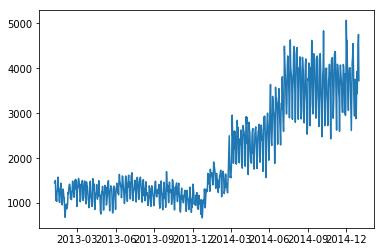

In [55]:
# Plot the dates later with matplotlib
plt.plot(train_set.groupby([id_date])['date_time'].count())

### Further Analysis: srch_ci, srch_co

In [ ]:
columns_to_change = ['srch_ci', 'srch_co']
for col in columns_to_change:
    train_set.loc[:, col] = pd.to_datetime(train_set.loc[:, col])

### General Train data statistics

#### date_time

In [6]:
# Firstly I need to 

## Let's explore both sets:
1. Common columns
* Dimensions
* dtypes
* unique values (for categorization)
* Nulls
* 
*

In [8]:
# COMMON COLUMNS
setA = pd.DataFrame({'Train': train_set.columns})
setB = pd.DataFrame({'Train': test_set.columns, 'Test': ['X' for x in range(test_set.shape[1])]})
pd.merge(setA, setB, how='outer', left_on='Train', right_on='Train')

,Train,Test
0,date_time,X
1,site_name,X
2,posa_continent,X
3,user_location_country,X
4,user_location_region,X
5,user_location_city,X
6,orig_destination_distance,X
7,user_id,X
8,is_mobile,X
9,is_package,X


In [5]:
# Dimensions
train_set.shape, test_set.shape

((1000000, 24), (10000, 22))

In [9]:
# DATA TYPES
train_set.dtypes

date_time                     object
site_name                      int64
posa_continent                 int64
user_location_country          int64
user_location_region           int64
user_location_city             int64
orig_destination_distance    float64
user_id                        int64
is_mobile                      int64
is_package                     int64
channel                        int64
srch_ci                       object
srch_co                       object
srch_adults_cnt                int64
srch_children_cnt              int64
srch_rm_cnt                    int64
srch_destination_id            int64
srch_destination_type_id       int64
is_booking                     int64
cnt                            int64
hotel_continent                int64
hotel_country                  int64
hotel_market                   int64
hotel_cluster                  int64
dtype: object

important: below nulls for test set is lower due to not loading the whole data but only 100000 rows.

In [10]:
# % OF NULL VALUES
setA = (train_set.isnull().sum() / train_set.shape[0]) * 100
setB = (test_set.isnull().sum() / test_set.shape[0]) * 100
pd.concat([setA, setB], join='outer', axis=1, keys=('Train', 'Test'))

,Train,Test
channel,0.0000,0.00
cnt,0.0000,NaN
date_time,0.0000,0.00
hotel_cluster,0.0000,NaN
hotel_continent,0.0000,0.00
hotel_country,0.0000,0.00
hotel_market,0.0000,0.00
id,NaN,0.00
is_booking,0.0000,NaN
is_mobile,0.0000,0.00


In [11]:
# UNIQUE VALUES IN EACH COLUMN
#setB = test_set.apply(lambda x: x.value_counts().count())
#pd.concat([setA, setB], axis=1, keys=('Train', 'Test'))

date_time                    987199
site_name                        42
posa_continent                    5
user_location_country           183
user_location_region            776
user_location_city            12920
orig_destination_distance    400861
user_id                       32783
is_mobile                         2
is_package                        2
channel                          11
srch_ci                        1108
srch_co                        1111
srch_adults_cnt                  10
srch_children_cnt                10
srch_rm_cnt                       9
srch_destination_id           16964
srch_destination_type_id          8
is_booking                        2
cnt                              49
hotel_continent                   7
hotel_country                   202
hotel_market                   2049
hotel_cluster                   100
dtype: int64

In [12]:
lista = []
for col in range(len(test_set.columns)):
    lista.append(test_set.iloc[:, col].value_counts().count())
pd.Series(lista, index=test_set.columns)

id                           10000
date_time                     9996
site_name                       30
posa_continent                   5
user_location_country          107
user_location_region           427
user_location_city            2682
orig_destination_distance     5878
user_id                       4665
is_mobile                        2
is_package                       2
channel                         11
srch_ci                        583
srch_co                        576
srch_adults_cnt                 10
srch_children_cnt                7
srch_rm_cnt                      9
srch_destination_id           3372
srch_destination_type_id         8
hotel_continent                  7
hotel_country                  137
hotel_market                  1363
dtype: int64

## Prepare Datasets for analysis:
1. convert dates to dates format
2. Remove nulls from:
	- srch_ci, srch_co by 

In [13]:
# CONVERT DATES TO DATETIME type
columns_to_change = ['date_time', 'srch_ci', 'srch_co']

for col in columns_to_change:
    train_set.loc[:, col] = pd.to_datetime(train_set.loc[:, col])
for col in columns_to_change:
    test_set.loc[:, col] = pd.to_datetime(test_set.loc[:, col])

In [162]:
# REMOVE NULL VALUES
train_set.loc[:, ['srch_ci', 'srch_co']].removenull()


Because of the size of train data set and small number of nulls in search_ci, search_co I decided to simply delete those observations.